In [4]:
import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import matplotlib.pyplot as plt

seed_val = 213
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

In [5]:
# If there's a GPU available...
#if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
#    device = torch.device("cuda")
#    print('There are %d GPU(s) available.' % torch.cuda.device_count())
#    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
#else:
#    print('No GPU available, using the CPU instead.')
device = torch.device("cpu")

In [6]:
import csv

def load_dataset_examples(input_file, skip_first_row):
  examples = []
  labels = []

  with open(input_file, "r", encoding="utf8") as infile:
   reader = csv.reader(infile, delimiter='\1')
   if skip_first_row:
      next(reader, None)  # skip the headers
   for row in reader:
      text = row[2]
      label = row[3]
      labels.append(label)
      examples.append((text, label))

  return examples, set(labels)

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv(".csv", sep='___', engine='python')

training_data, testing_data = train_test_split(df, test_size=0.30, random_state=9)


tsv = training_data.to_csv(sep='\1', index=False) # use '\1' if your data contains tabs
#psv = tsv.replace('\1', '___')
with open("data_train.csv", 'w', encoding='utf-8', newline='\n') as outfile:
    outfile.write(tsv)

tsv1 = testing_data.to_csv(sep='\1', index=False) # use '\1' if your data contains tabs
#psv1 = tsv1.replace('\1', '___')
with open("data_test.csv", 'w', encoding='utf-8', newline='\n') as outfile:
    outfile.write(tsv1)

train = "data_train.csv"
test = "data_test.csv"
train_examples, train_labels = load_dataset_examples(train, skip_first_row=True)
test_examples, test_labels = load_dataset_examples(test, skip_first_row=True)



In [8]:
print("Some training examples:\n")

for i in range(1, 10):
  print(train_examples[i])

Some training examples:

('Allarme focolaio Covid a San Giorgio a Cremano, popoloso comune in provincia di Napoli: a rischio una residenza per anziani privata. Ci sarebbero ben 60 positivi su 80 presenti, fra cui anche lavoratori. Nella città vesuviana il bilancio è già serio: 106 i positivi, 15 soltanto nelle ultime ore.', 'Coronavirus - Focolai RSA/Case di riposo')
("Coronavirus: focolaio all'interno del Campus Universitario / VIDEO „  Firenze, 26 aprile 2021 - Doppio focolaio di variante brasiliana in due studentati universitari di Firenze: per ora ci sono sessanta ragazzi contagiati, la maggioranza priva di sintomi o con manifestazioni leggere del virus. Ma la situazione è ugualmente preoccupante. E per ragioni varie e diverse. Si tratta di due cluster separati, uno allo studentato Campus X di viale Morgagni, con 42 positivi con variante brasiliana su circa 150 ospiti, l’altro con 18 casi alla residenza universitaria Villa Val di Rose al Polo scientifico di Sesto Fiorentino.  Entra

In [9]:
# This is a multi-class classification task. 
label_list = list(train_labels.union(test_labels))
label_list.sort()
# Let us print the labels used in the dataset
print("Target Labels:\t" + str(label_list))
print("Number of Labels:\t" + str(len(label_list)))

Target Labels:	['Coronavirus - Focolai RSA/Case di riposo', 'Coronavirus - Focolai familiari/amici', 'Coronavirus - Focolai in altri contesti', 'Coronavirus - Focolai ospedalieri', 'Coronavirus - Focolai scolastico', 'Coronavirus - VARIANTI']
Number of Labels:	6


In [10]:
#--------------------------------------------
#  English models
# --------------------------------------------
#model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "bert-large-cased"
#model_name = "bert-large-uncased"
#model_name = "bert-large-uncased-whole-word-masking"

#model_name = "roberta-base"
#model_name = "roberta-large"

#model_name = "albert-base-v2"
#model_name = "albert-large-v2"
#model_name = "albert-xlarge-v2"

#model_name = "google/electra-base-discriminator"

#model_name = "distilbert-base-cased"
#model_name = "distilbert-base-uncased"

# --------------------------------------------
#  Multilingual models
# --------------------------------------------
#model_name = "bert-base-multilingual-cased" #the uncased should not be used
#model_name = "xlm-roberta-base"

# --------------------------------------------
#  Italian models (my language) 
# --------------------------------------------
#model_name = "m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0"
model_name = "Musixmatch/umberto-commoncrawl-cased-v1"

# Notice that a lot of models pre-trained for specific languages are available
# at https://huggingface.co/models

In [11]:
class Classifier(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout_rate=0.1):
      super(Classifier, self).__init__()
      # Load the BERT-based encoder
      self.encoder = AutoModel.from_pretrained(model_name)
      # The AutoConfig allows to access the encoder configuration. 
      # The configuration is needed to derive the size of the embedding, which 
      # is produced by BERT (and similar models) to encode the input elements. 
      config = AutoConfig.from_pretrained(model_name)
      self.cls_size = int(config.hidden_size)
      # Dropout is applied before the final classifier
      self.input_dropout = nn.Dropout(p=dropout_rate)
      # Final linear classifier
      self.fully_connected_layer = nn.Linear(self.cls_size,num_labels)

    def forward(self, input_ids, attention_mask):
      # encode all outputs
      model_outputs = self.encoder(input_ids, attention_mask)
      # just select the vector associated to the [CLS] symbol used as
      # first token for ALL sentences
      encoded_cls = model_outputs.last_hidden_state[:,0]
      # apply dropout
      encoded_cls_dp = self.input_dropout(encoded_cls)
      # apply the linear classifier
      logits = self.fully_connected_layer(encoded_cls_dp)
      # return the logits
      return logits, encoded_cls

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /home/paoloc/.cache/huggingface/hub/models--Musixmatch--umberto-commoncrawl-cased-v1/snapshots/fe7b14808cccbbe2984b05e6fbfd71127f11008f/config.json
Model config CamembertConfig {
  "_name_or_path": "Musixmatch/umberto-commoncrawl-cased-v1",
  "architectures": [
    "CamembertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "

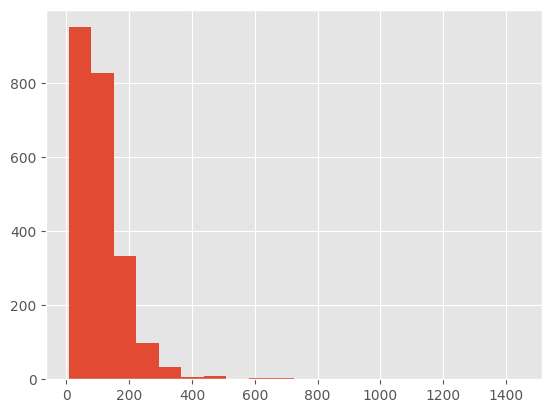

In [12]:
# Define a Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

#Print the length distribution
plt.style.use("ggplot")
plt.hist([len(tokenizer.encode_plus(text)["input_ids"]) for text, label in train_examples], bins=20)
plt.show()

In [13]:
# --------------------------------
# Encoder (i.e., BERT) parameters
# --------------------------------

# the maximum length to be considered in input
max_seq_length = 512
# dropout applied to the embedding produced by BERT before the classifiation
out_dropout_rate = 0.2

# --------------------------------
# Training parameters
# --------------------------------

# Dev percentage split, i.e., the percentage of training material to be use for
# evaluating the model during training
dev_perc = 0.1

# the batch size
batch_size = 6

# the learning rate used during the training process
learning_rate = 1e-5 
# if you use large models (such as Bert-large) it is a good idea to use 
# smaller values, such as 5e-6

# name of the fine_tuned_model
output_model_name = "best_model.pickle"

# number of training epochs
num_train_epochs = 5

# ADVANCED: Schedulers allow to define dynamic learning rates.
# You can find all available schedulers here
# https://huggingface.co/transformers/main_classes/optimizer_schedules.html
apply_scheduler = False
# Here a `Constant schedule with warmup`can be activated. More details here
# https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_constant_schedule_with_warmup
warmup_proportion = 0.1

# --------------------------------
# Log parameters
# --------------------------------

# Print a log each n steps
print_each_n_step = 10

In [14]:
def generate_data_loader(examples, label_map, tokenizer, do_shuffle = False):
  '''
  Generate a Dataloader given the input examples

  examples: a list of pairs (input_text, label)
  label_mal: a dictionary used to assign an ID to each label
  tokenize: the tokenizer used to convert input sentences into word pieces
  do_shuffle: a boolean parameter to shuffle input examples (usefull in training) 
  ''' 
  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_id_array = []

  # Tokenization 
  for (text, label) in examples:
    # tokenizer.encode_plus is a crucial method which:
    # 1. tokenizes examples
    # 2. trims sequences to a max_seq_length
    # 3. applies a pad to shorter sequences
    # 4. assigns the [CLS] special wor-piece such as the other ones (e.g., [SEP])
    encoded_sent = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_seq_length, padding='max_length', truncation=True)
    # convert input word pieces to IDs of the corresponding input embeddings
    input_ids.append(encoded_sent['input_ids'])
    # store the attention mask to avoid computations over "padded" elements
    input_mask_array.append(encoded_sent['attention_mask'])
  
    # converts labels to IDs
    id = -1
    if label in label_map:
      id = label_map[label]
    label_id_array.append(id)
       
  # Convert to Tensor which are used in PyTorch
  input_ids = torch.tensor(input_ids) 
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  
  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array)

  if do_shuffle:
    # this will shuffle examples each time a new batch is required
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset), # the adopted sampler
              batch_size = batch_size) # Trains with this batch size.

In [15]:
# Initialize a map to associate labels to the dimension of the embedding 
# produced by the classifier
label_to_id_map = {}
id_to_label_map = {}
for (i, label) in enumerate(label_list):
  label_to_id_map[label] = i
  id_to_label_map[i] = label

# Shuffle and split the training material in train/dev
random.shuffle(train_examples)
train_subset_examples = train_examples[int(len(train_examples) * 0) : int(len(train_examples) * (1-dev_perc))]
dev_subset_examples = train_examples[int(len(train_examples) * (1-dev_perc)) : int(len(train_examples))]

# Build the Train Dataloader
train_dataloader = generate_data_loader(train_subset_examples, label_to_id_map, tokenizer, do_shuffle = True)
# Build the Development Dataloader
dev_dataloader = generate_data_loader(dev_subset_examples, label_to_id_map, tokenizer, do_shuffle = True)
# Build the Test DataLoader
test_dataloader = generate_data_loader(test_examples, label_to_id_map, tokenizer, do_shuffle = False)

print("Number of training examples:\t"+ str(len(train_subset_examples)))
print("Number of development examples:\t"+ str(len(dev_subset_examples)))
print("Number of test examples:\t"+ str(len(test_examples)))

Number of training examples:	2043
Number of development examples:	228
Number of test examples:	974


In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sys


def evaluate(dataloader, classifier, print_classification_output=False, print_result_summary=False):

  '''
  Evaluation method which will be applied to development and test datasets.
  It returns the pair (average loss, accuracy)
  
  dataloader: a dataloader containing examples to be classified
  classifier: the BERT-based classifier
  print_classification_output: to log the classification outcomes 
  ''' 
  total_loss = 0
  gold_classes = [] 
  system_classes = []
 
  if print_classification_output:
      print("\n------------------------")
      print("  Classification outcomes")
      print("is_correct\tgold_label\tsystem_label\ttext")
      print("------------------------")

  # For each batch of examples from the input dataloader
  for batch in dataloader:   
    # Unpack this training batch from our dataloader. Notice this is populated 
    # in the method `generate_data_loader`
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():
      # Each batch is classifed        
      logits, _ = classifier(b_input_ids, b_input_mask)
      # Evaluate the loss. 
      total_loss += nll_loss(logits, b_labels)
        
    # Accumulate the predictions and the input labels
    _, preds = torch.max(logits, 1)
    system_classes += preds.detach().cpu()
    gold_classes += b_labels.detach().cpu()

    # Print the output of the classification for each input element
    if print_classification_output:
      for ex_id in range(len(b_input_mask)):
        input_strings = tokenizer.decode(b_input_ids[ex_id], skip_special_tokens=True)
        # convert class id to the real label
        predicted_label = id_to_label_map[preds[ex_id].item()]
        gold_standard_label = "UNKNOWN"
        # convert the gold standard class ID into a real label
        if b_labels[ex_id].item() in id_to_label_map:
          gold_standard_label = id_to_label_map[b_labels[ex_id].item()]
        # put the prefix "[OK]" if the classification is correct
        output = '[OK]' if predicted_label == gold_standard_label else '[NO]'
        # print the output
        print(output+"\t"+gold_standard_label+"\t"+predicted_label+"\t"+input_strings)

  # Calculate the average loss over all of the batches.
  avg_loss = total_loss / len(dataloader)
  avg_loss = avg_loss.item()

  # Report the final accuracy for this validation run.
  system_classes = torch.stack(system_classes).numpy()
  gold_classes = torch.stack(gold_classes).numpy()
  accuracy = np.sum(system_classes == gold_classes) / len(system_classes)

  if print_result_summary:
    print("\n------------------------")
    print("  Summary")
    print("------------------------")
    #remove unused classes in the test material
    filtered_label_list = []
    for i in range(len(label_list)):
      if i in gold_classes:
        filtered_label_list.append(id_to_label_map[i])
    print(classification_report(gold_classes, system_classes, digits=3, target_names=filtered_label_list))

    print("\n------------------------")
    print("  Confusion Matrix")
    print("------------------------")
    conf_mat = confusion_matrix(gold_classes, system_classes)
    for row_id in range(len(conf_mat)):
      print(filtered_label_list[row_id]+"\t"+str(conf_mat[row_id]))
         
  return avg_loss, accuracy

In [17]:
classifier = Classifier(model_name, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
#if torch.cuda.is_available():    
  #classifier.cuda()

# Define the Optimizer. Here the ADAM optimizer (a sort of standard de-facto) is
# used. AdamW is a variant which also adopts Weigth Decay.
optimizer = torch.optim.AdamW(classifier.parameters(), lr=learning_rate)
# More details about the Optimizers can be found here:
# https://huggingface.co/transformers/main_classes/optimizer_schedules.html

# Define the scheduler
if apply_scheduler:
  # Estimate the numbers of step corresponding to the warmup.
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)
  # Initialize the scheduler
  scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps = num_warmup_steps)

loading configuration file config.json from cache at /home/paoloc/.cache/huggingface/hub/models--Musixmatch--umberto-commoncrawl-cased-v1/snapshots/fe7b14808cccbbe2984b05e6fbfd71127f11008f/config.json
Model config CamembertConfig {
  "_name_or_path": "Musixmatch/umberto-commoncrawl-cased-v1",
  "architectures": [
    "CamembertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 5,
  "classifier_dropout": null,
  "eos_token_id": 6,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.22.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 32005
}

loading weights file pytorch_model.bin from cache at /home/paoloc/.cach

In [18]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)


In [19]:
training_stats = []


# Define the LOSS function. A CrossEntropyLoss is used for multi-class 
# classification tasks. 
nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)
# All loss functions are available at:
# - https://pytorch.org/docs/stable/nn.html#loss-functions

# Measure the total training time for the whole run.
total_t0 = time.time()

# NOTICE: the measure to be maximized should depends on the task. 
# Here accuracy is used.
best_dev_accuracy = -1

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    train_loss = 0

    # Put the model into training mode.
    classifier.train() 

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        train_logits, _ = classifier(b_input_ids, b_input_mask)
        # calculate the loss        
        loss = nll_loss(train_logits, b_labels)      
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward() 
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()
    
        # Update the learning rate with the scheduler, if specified
        if apply_scheduler:
          scheduler.step()
    
    # Calculate the average loss over all of the batches.
    avg_train_loss = train_loss / len(train_dataloader)
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #     Evaluate on the Development set
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    classifier.eval()

    # Apply the evaluate_method defined above to estimate 
    avg_dev_loss, dev_accuracy = evaluate(test_dataloader, classifier)

    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)

    print("  Accuracy: {0:.3f}".format(dev_accuracy))
    print("  Test Loss: {0:.3f}".format(avg_dev_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_dev_loss,
            'Valid. Accur.': dev_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )

    # Save the model if the performance on the development set increases
    if dev_accuracy > best_dev_accuracy:
      best_dev_accuracy = dev_accuracy
      torch.save(classifier, output_model_name)
      print("\n  Saving the model during epoch " + str(epoch_i))
      print("  Actual Best Validation Accuracy: {0:.3f}".format(best_dev_accuracy))


======== Epoch 1 / 5 ========
Training...
  Batch    10  of    341.    Elapsed: 0:01:11.
  Batch    20  of    341.    Elapsed: 0:02:26.
  Batch    30  of    341.    Elapsed: 0:03:41.
  Batch    40  of    341.    Elapsed: 0:04:57.
  Batch    50  of    341.    Elapsed: 0:06:04.
  Batch    60  of    341.    Elapsed: 0:06:57.
  Batch    70  of    341.    Elapsed: 0:07:50.
  Batch    80  of    341.    Elapsed: 0:08:44.
  Batch    90  of    341.    Elapsed: 0:09:37.
  Batch   100  of    341.    Elapsed: 0:10:31.
  Batch   110  of    341.    Elapsed: 0:11:25.
  Batch   120  of    341.    Elapsed: 0:12:19.
  Batch   130  of    341.    Elapsed: 0:13:13.
  Batch   140  of    341.    Elapsed: 0:14:06.
  Batch   150  of    341.    Elapsed: 0:15:00.
  Batch   160  of    341.    Elapsed: 0:15:54.
  Batch   170  of    341.    Elapsed: 0:16:48.
  Batch   180  of    341.    Elapsed: 0:17:42.
  Batch   190  of    341.    Elapsed: 0:18:35.
  Batch   200  of    341.    Elapsed: 0:19:28.
  Batch   210  of

{'epoch': 1, 'Training Loss': 1.041094040328806, 'Valid. Loss': 0.5308970808982849, 'Valid. Accur.': 0.8562628336755647, 'Training Time': '0:31:58', 'Test Time': '0:04:20'}
{'epoch': 2, 'Training Loss': 0.48681478346547774, 'Valid. Loss': 0.46447187662124634, 'Valid. Accur.': 0.8583162217659137, 'Training Time': '0:31:31', 'Test Time': '0:04:10'}
{'epoch': 3, 'Training Loss': 0.34267115210595367, 'Valid. Loss': 0.4940434694290161, 'Valid. Accur.': 0.8459958932238193, 'Training Time': '0:29:05', 'Test Time': '0:04:13'}
{'epoch': 4, 'Training Loss': 0.26954124409082697, 'Valid. Loss': 0.4902850091457367, 'Valid. Accur.': 0.8593429158110883, 'Training Time': '0:29:16', 'Test Time': '0:04:04'}
{'epoch': 5, 'Training Loss': 0.2063813074724066, 'Valid. Loss': 0.5041868686676025, 'Valid. Accur.': 0.8593429158110883, 'Training Time': '0:28:12', 'Test Time': '0:04:02'}


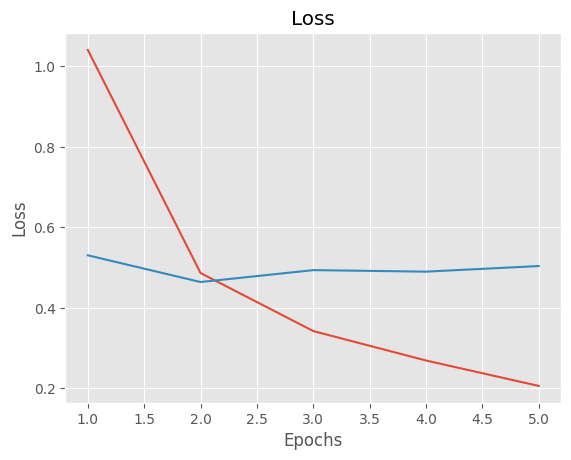

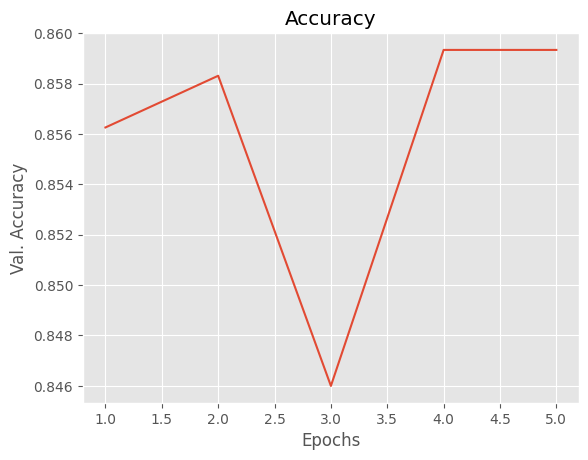


Training complete!
Total training took 17:08:17 (h:mm:ss)


In [21]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for stat in training_stats:
  train_losses.append(stat["Training Loss"])
  val_losses.append(stat["Valid. Loss"])
  val_acc.append(stat["Valid. Accur."])
  print(stat)

plt.plot(range(1,num_train_epochs+1), train_losses, label = "Training Loss")
plt.plot(range(1,num_train_epochs+1), val_losses, label = "Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

plt.plot(range(1,num_train_epochs+1), val_acc, label = "Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Val. Accuracy")
plt.show()

print("\nTraining complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [22]:
# Load the best model and save it
best_model = torch.load(output_model_name)
torch.save(best_model, 'model_def.pt')
torch.save(best_model.state_dict(), 'state_dict_model_def.pth')

# Evaluate it
avg_test_loss, test_accuracy = evaluate(test_dataloader, best_model, print_classification_output = True, print_result_summary=True)

print("\n\n  Accuracy: {0:.3f}".format(test_accuracy))
print("  Test Loss: {0:.3f}".format(avg_test_loss))


------------------------
  Classification outcomes
is_correct	gold_label	system_label	text
------------------------
[OK]	Coronavirus - Focolai ospedalieri	Coronavirus - Focolai ospedalieri	CATANIA - A Catania a causa dei 15 contagiri Coronavirus registrati è stato chiuso il reparto di neurochirurgia dell’ospedale San Marco. Lo rende noto la Fsi-Usae, che aveva chiesto formalmente all’Azienda di valutare la chiusura temporanea al fine di sanificare i locali interessati
[OK]	Coronavirus - Focolai scolastico	Coronavirus - Focolai scolastico	Recentemente è scoppiato il contagio a Scala, in costiera amalfitana, dove probabilmente il virus ha trovato l’occasione di galoppare ancor più velocemente e con più efficacia nelle scuole. Ecco che arriva un messaggio dal sindaco di Scala e dall’amministrazione comunale, che invoca a mantenere la calma. Dunque, i cluster che si sono sviluppati nei giorni scorsi e hanno portato il numero di positivi a triplicare in poco tempo, secondo l’amministrazion